# Triton Basics
<a target="_blank" href="https://colab.research.google.com/github/Tcc0402/gpu-100-days/blob/main/day003/triton_vector_add.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!nvidia-smi

Fri Feb 13 18:11:41 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import triton
import triton.language as tl

In [3]:
DEVICE = 'cuda'

In [ ]:
!mkdir "benchmark"

## Write a reference kernel as baseline

In [4]:
def ref_vector_add(x, y):
    output = torch.add(x, y)
    return output

## Write Triton kernel

In [5]:
@triton.jit
def vector_add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    result = x + y
    tl.store(output_ptr + offsets, result, mask=mask)

## Helper function to allocate tensors

In [6]:
def triton_vector_add(x, y):
    output = torch.empty_like(x)
    size = x.numel()
    BLOCK_SIZE = 1024

    # grid = lambda META: (triton.cdiv(size, META['BLOCK_SIZE']),)
    grid = (triton.cdiv(size, BLOCK_SIZE),)
    vector_add_kernel[grid](x, y, output, size, BLOCK_SIZE=BLOCK_SIZE)

    return output


## Test the correctness

In [7]:
def test():
    size = 1024
    x = torch.randn(size, device=DEVICE)
    y = torch.randn(size, device=DEVICE)
    output_ref = ref_vector_add(x, y)

    output_triton = triton_vector_add(x, y)

    if torch.allclose(output_ref, output_triton, atol=1e-6):
        print("✅ Triton kernel is correct!")
    else:
        print("❌ Triton kernel is incorrect.")

test()

✅ Triton kernel is correct!


## Benchmark with `triton.testing.do_bench`

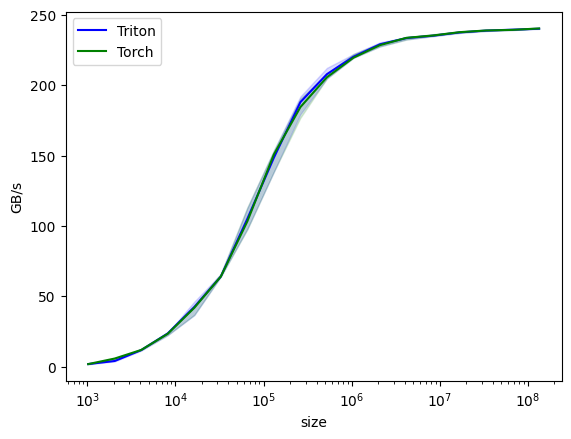

FileNotFoundError: [Errno 2] No such file or directory: '/benchmark/vector-add-performance.png'

<Figure size 640x480 with 0 Axes>

In [ ]:
import os

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2 ** i for i in range(10, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ref_vector_add(x, y), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_vector_add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True, save_path=os.path.abspath("./benchmark"))